# Семинар 04 – Линейные модели в задачах классификации

<a id="Content"></a>
# Содержание
0. [Постановка задачи](#0)
1. [Метрики классификации](#1)
   - [Точность ответов (precision)](#1.1)
   - [Полнота ответов (recall)](#1.2)
   - [Доля правильных ответов (accuracy)](#1.3)
   - [F-score](#1.4)
   - [ROC-AUC score](#1.5)
   - [Метрики многоклассовой классификации](#1.6)
2. [Линейный модели для задачи классификации](#2)
   - [Логистическая регрессия для задачи многоклассовой классификации](#2.1)
   - [Solvers](#2.2)
3. [Intro to PyTorch](#3)
   - [Синтаксис](#3.1)
   - [Операции в PyTorch](#3.2)
   - [Matrix Operations](#3.3)
   - [From NumPy to PyTorch conversation](#3.4)
   - [CUDA](#3.5)
4. [High-level PyTorch](#4)
5. [Ссылки](#5)
6. [Что почитать](#6)

In [5]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as st
import warnings
warnings.simplefilter('ignore')

<a id="0"></a>
# 0. Постановка задачи

![picture](logreg.png)

Где линейная модель - это: $$ \hat{y} = f(x) = \theta_0*1 + \theta_1*x_1 + ... + \theta_n*x_n = \theta^T*X$$

Зачем нам нужна логистическая регрессия? 
$$ p_{\text{+}} = P(y = 1|X) \in [0, 1] $$
$$y_{\text{pred}} \in \mathbb{R}$$

Хотим рациональное значение, полученное из линейной регрессии перевести в вероятность принадлежности данному классу:

$$ \frac {p_{\text{+}}}{1 - p_{\text{+}}} \in [0, +\infty) $$
$$ log{\frac {p_{\text{+}}}{1 - p_{\text{+}}}} \in \mathbb{R} $$

Получаем:

$$
p_{\text{+}} = \frac {1}{1 + e^{-\theta^T*X}} = \sigma(\theta^T*X) \in [0, 1]
$$


<a id="1"></a>
# 1. Метрики классификации

In [6]:
from sklearn.datasets import fetch_olivetti_faces

In [7]:
data = fetch_olivetti_faces()
data.target

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

In [8]:
X, y = data.data, data.target

In [9]:
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)
rng = 0

# #############################################################################
# Load faces data
faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True,
                                random_state=rng)
n_samples, n_features = faces.shape

def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

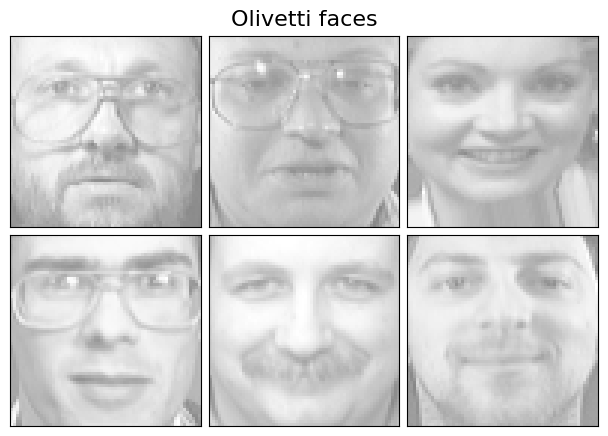

In [10]:
plot_gallery("Olivetti faces", faces[:n_components])

### Подготовим заведомо несбалансированную выборку (3 класса)

In [11]:
indx_0 = np.where(y == 0)[0]
indx_1 = np.where(y == 1)[0][:len(indx_0)]
print(indx_0)
print(indx_1)

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]


In [12]:
indx_2 = np.where(y == 2)[0][:3]
indx_2

array([20, 21, 22], dtype=int64)

In [13]:
X = X[np.concatenate((np.concatenate((indx_1, indx_0)), indx_2))]
y = y[np.concatenate((np.concatenate((indx_1, indx_0)), indx_2))]

In [14]:
print('В датасете {} объектов и {} признака'.format(X.shape[0], X.shape[1]))

В датасете 23 объектов и 4096 признака


### Разделим выборку на две части: обучающую и тестовую

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.5,
                                                    test_size=0.5,
                                                    shuffle=True,
                                                   random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11, 4096), (12, 4096), (11,), (12,))

In [17]:
from sklearn.neighbors import KNeighborsClassifier

Зададим классификатор:

In [18]:
knn = KNeighborsClassifier(n_neighbors=5)

In [19]:
knn.fit(X_train, y_train)
knn_predictons = knn.predict(X_test)

In [20]:
preds = pd.DataFrame(y_test, columns=['True'])
preds['knn_pred'] = knn_predictons

In [21]:
preds

,True,knn_pred
0,0,0
1,1,1
2,1,1
3,1,1
4,0,0
5,0,0
6,1,1
7,0,0
8,1,1
9,1,1


Что можно заметить?
На 0 и 1 класса классификатор отработал хорошо, но 2 класс он не видел и не смог его определить

![img](metrics_class.jpg)

<a id="1.1"></a>
## 1.1. Точность ответов (precision)

$$
\text{Precision} = \frac{TP}{TP + FP}$$

*Простыми словами*: какая доля предсказаний оказалась правильной

*Пример*: В задаче классификации писем на спам/не спам нам важнее не отправить важное письмо (label = -1) в мусорку, даже если пропустим спам (label = 1). То есть мы хотим уменьшать количество на FP (ошибки I рода), когда мы истинно негативный класс (не спам) относим к положительному (спам).ссов.

**Задание 0**: Реализовать поиск метрики precision для случая, когда класс 1 - это позитивный класс. Метрику посчитать без учета различных классов.

In [22]:
y_test, knn_predictons

(array([0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 2]),
 array([0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1]))

In [23]:
def precision(true, predictions):
    # Выбираем класс 1 как True
    TP = 0
    FP = 0
    
        #YOUR_CODE_HERE
    
    prec = TP/(TP+FP)
    return prec

precision(y_test, knn_predictons)

ZeroDivisionError: division by zero

Тоже самое средставми sklearn:

In [24]:
from sklearn.metrics import precision_score
precision_score(y_test, knn_predictons, labels=[1], average='micro')

0.8571428571428571

<a id="1.2"></a>
## 1.2. Полнота ответов (recall)

$$
\text{Recall} = \frac{TP}{TP + FN}$$

*Простыми словами*: какую долю из всех объектов положительного класса алгоритм нашёл правильно

*Пример*: В задаче классификации больной человек/здоровый нам важно не пропустить всех больных (label = 1), даже если определили здорового человека (label = -1) больным. То есть мы хотим уменьшать количество FN (ошибки II рода), когда мы истинно положительный класс (больной человек) отнесли к негативному (здоровый человек).ves)

**Задание 1**: Реализовать поиск метрики recall для случая, когда класс 1 - это позитивный класс. Метрику посчитать без учета различных классов.

In [ ]:
def recall(true, predictions):
    TP = 0
    FN = 0

        #YOUR_CODE_HERE

    rec = TP/(TP+FN)
    return rec
recall(y_test, knn_predictons)

Тоже самое средставми sklearn:

In [25]:
from sklearn.metrics import recall_score
recall_score(y_test, knn_predictons, labels=[1], average='micro')

1.0

<a id="1.3"></a>
## 1.3. Доля правильных ответов (accuracy)

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

*Простыми словами*: просто считаем сколько предсказали правильно любый классов по отношению вообще ко всем предсказаниям\]

In [26]:
def accuracy(true, predictions):
    acc = predictions[true == predictions].shape[0] / true.shape[0] 
    return acc
accuracy(y_test, knn_predictons)

0.9166666666666666

Тоже самое средставми sklearn:

In [27]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, knn_predictons)

0.9166666666666666

<a id="1.4"></a>
## 1.4. F-score

*Простыми словами*: хотим агрегировать precision и recall

$$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

F1-мера - это частный случай F_beta-меры:

$$
F_\beta = (1 + \beta^2) \cdot \frac{\text{Precision} \cdot \text{Recall}}{\beta^2 \cdot \text{Precision} + \text{Recall}}$$

Если нам важнее precision:
$$
\beta \in(0,  1]$$

Если же нам важнее recall:
$$
\beta > 1
$$

*Пример*: если болезнь страшная, то мы хотим и precision учитывать, но recall всё ещё важнее\]\]\]

In [28]:
def F1_score(true, predictions):
    f1 = 2*(recall(true, predictions)*precision(true, predictions))/(recall(true, predictions)+precision(true, predictions))
    return f1
F1_score(y_test, knn_predictons)

NameError: name 'recall' is not defined

Тоже самое средставми sklearn:

In [29]:
from sklearn.metrics import f1_score
f1_score(y_test, knn_predictons, labels=[1], average='micro')

0.9230769230769231

<a id="1.5"></a>
## 1.5. ROC-AUC score

![img](roc_auc.png)

$$
\text{TPR} = \frac{TP}{TP + FN}$$

TPR - истинная положительная доля

$$
\text{FPR} = \frac{FP}{FP + TN}$$

FPR - ложная положительная доля\]\]

Для этого, в отличае от других метрий, нам понадобятся не предсказания модели, а вероятности принадлежности классам, которые модель выдает.

In [30]:
probs = knn.predict_proba(X_test)

Также необходибо бинаризовать метки классов для подсчета TPR и FPR

In [31]:
from sklearn.preprocessing import label_binarize
counts = np.unique(y, return_counts=True)
y_test_bin = label_binarize(y_test, classes=counts[0])

In [32]:
y_test_bin

array([[1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1]])

Считаем TPR и FPR для каждого класса

In [33]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in counts[0]:
    fpr[i], tpr[i], threshold = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [34]:
roc_auc

{0: 1.0, 1: 1.0, 2: 0.9545454545454546}

In [35]:
fpr["micro"], tpr["micro"], threshold = roc_curve(y_test_bin.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
roc_auc["micro"]

0.9791666666666667

In [36]:
threshold, probs.ravel()

(array([inf, 1. , 0.8, 0.6, 0.4, 0.2, 0. ]),
 array([0.6, 0.4, 0. , 0.2, 0.8, 0. , 0.2, 0.8, 0. , 0. , 0.8, 0.2, 1. ,
        0. , 0. , 0.8, 0.2, 0. , 0.2, 0.8, 0. , 0.6, 0.4, 0. , 0. , 0.8,
        0.2, 0.2, 0.8, 0. , 0.4, 0.2, 0.4, 0. , 0.6, 0.4]))

In [37]:
def plot_roc_curve(index=8):
    plt.figure()
    lw = 2
    plt.plot(fpr[index], tpr[index], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[index])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class {}'.format(index))
    plt.legend(loc="lower right")
    plt.show()

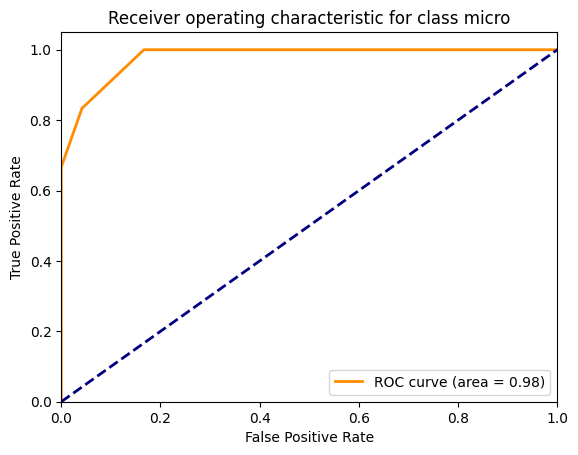

In [38]:
plot_roc_curve("micro")

<a id="1.6"></a>
## 1.6. Метрики многоклассовой классификации

1. **Микроусредненные метрики**:
Микроусреднение агрегирует информацию о всех классах, подсчитывая суммарные истинные положительные, ложные положительные и ложные отрицательные значения. Формулы для микроусредненных precision, recale выглядят так

$$
\text{Precision}_{\text{micro}} = \frac{\sum_{i} TP_i}{\sum_{i} (TP_i + FP_i)}
$$

$$
\text{Recall}_{\text{micro}} = \frac{\sum_{i} TP_i}{\sum_{i} (TP_i + FN_i)}
$$

*Зачем*: позволяет учитывать дисбаланс классов

2. **Макроусредненные метрики**:
Макроусреднение вычисляет метрики для каждого класса, а затем усредняет эти метрики. Формулы для макроусредненных precision, recore выглядят ть
$$
\text{Prescision}_{\text{macro}} = \frac{1}{K} \sum_{i} \frac{TP_i}{TP_i + FP_i}
$$

$$
\text{Recall}_{\text{macro}} = \frac{1}{K} \sum_{i} \frac{TP_i}{TP_i + FN_i}
$$

*Зачем*: одинаковый вклад каждого класса FN_i
\]

<a id="2"></a>
# 2. Линейные модели для задачи классификации
В качестве демонстрации будем использовальзовать датасет с изображениями цифр

In [39]:
# Загрузим данные
from sklearn.datasets import load_digits
digits = load_digits()

In [40]:
X = digits.data
y = digits.target

In [41]:
# Посмотрим на кол-во объектов
X.shape, y.shape

((1797, 64), (1797,))

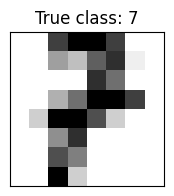

In [42]:
# Давайте, посмотрим, как вылядит случайный объект нашей выборки
target_image_id = np.random.randint(X.shape[0])

plt.figure(figsize=(4,2))
plt.imshow(X[target_image_id].reshape((8, 8)), cmap='binary')
plt.xticks([])
plt.yticks([])
plt.title('True class: '+ str(y[target_image_id]))
plt.show()

In [43]:
# Посмотрим на баланс классов
class_counts = np.unique(y, return_counts=True)

pd.DataFrame(class_counts[1], index=class_counts[0], columns=['Counts'])

,Counts
0,178
1,182
2,177
3,183
4,181
5,182
6,181
7,179
8,174
9,180


<a id="2.1"></a>
## 2.1. Логистическая регрессия для многоклассовой классификации

In [44]:
# Загрузим нужные библиотеки
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [45]:
# Разделим выборку на тренировочную и тестовую
x_train, x_test, y_train, y_test = train_test_split(X, y,
                 train_size=0.8, test_size=0.2, shuffle=True,
                 random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1437, 64), (360, 64), (1437,), (360,))

*Логистическая регрессия позволяет решать задачу многоклассовой классификации. Класс ``LogisticRegression`` позвляет это делать двумя способами:*
- Стандартный One vs Rest (т.е. каждый класс отделяется от всех других). Параметр `multi_class='ovr'`.*
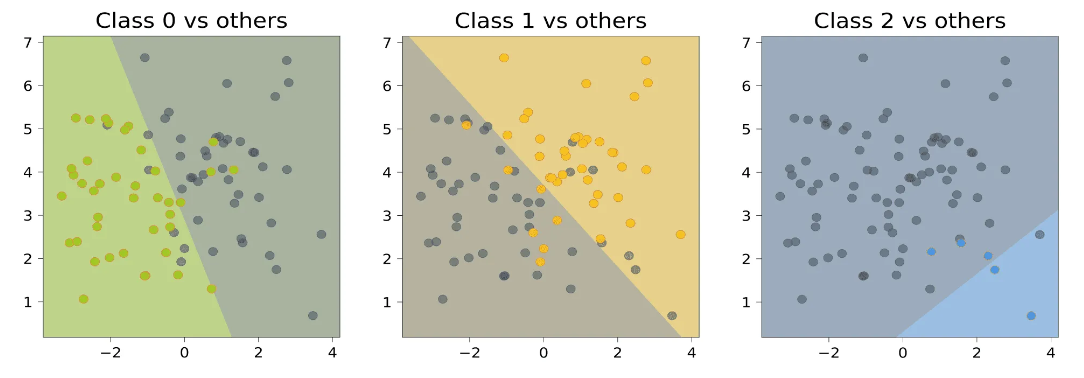
- One vs One: Используя кросс-энтропию (оценивается сразу вектор вероятностей принадлежности классам). Параметр `multi_class='multinomial'`.*
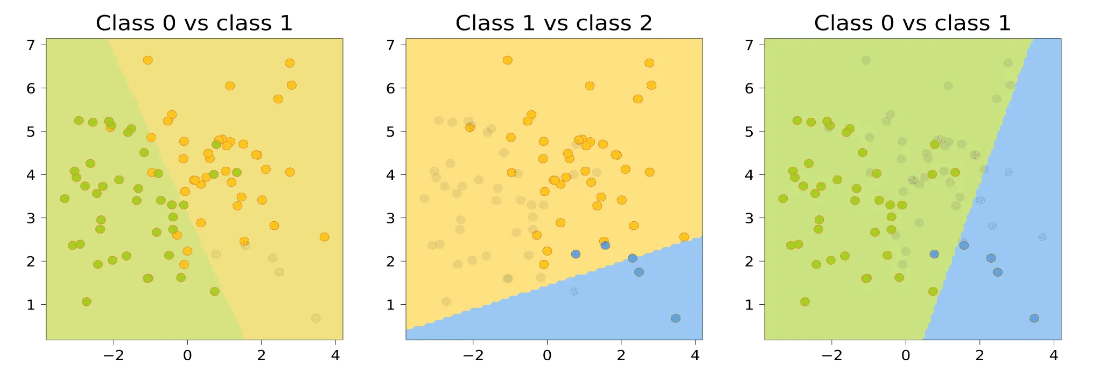

#### One vs Rest


Find 𝐾 − 1 classifiers 𝑓 , 𝑓 , ... , 𝑓 12 𝐾−1  
- 𝑓 classifies1𝑣𝑠{2,3,...,𝐾} 1
- 𝑓 classifies2𝑣𝑠{1,3,...,𝐾} 2
- ...
- 𝑓 classifies𝐾−1𝑣𝑠{1,2,...,𝐾−2}
- 𝐾−1
- Points not classified to classes {1,2, ... , 𝐾 − 1} are put to class 𝐾


#### One vs One (Cross-entropy)


В случае с бинарной (классы 0 и 1) классификацией функция потерь:
$$ \sum_{i=1}^l \bigl( y_i \log a_i - (1-y_i) \log (1-a_i) \bigr)  \rightarrow min$$  
$a_i$ – ответ (вероятность) алгоритма на i-м объекте на вопрос принадлежности к классу $y_i$

Обобщается для многомерного случая:
$$-\frac{1}{q} \sum_{i=1}^q \sum_{j=1}^l y_{ij} \log a_{ij} \rightarrow min $$
где  
$q$ – число элементов в выборке,  
$l$ – число классов,   
$a_{ij}$ – ответ (вероятность) алгоритма на i-м объекте на вопрос принадлежности его к j-му классу

__Проблемы:__

- Сложности в поиске глобального минимума, так как присутствуют Локальные минимумы и плато

<a id="2.2"></a>
## 2.2. Solvers

![picture](solvers.png)

Source: [User Guide](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

### Напоминание

1. **L1-регуляризация (Lasso)**:
L1-регуляризация добавляет штраф за сумму абсолютных значений коэффициентов к функции потерь. Формула выглядит следующим образом

$$
L_{\text{L1}} = \lambda \sum_{j=1}^{n} |w_j|
$$.

2. **L2-регуляризация (Ridge)**:
L2-регуляризация добавляет штраф за сумму квадратов коэффициентов к функции потерь. Формула выглядит следующим образом

$$
L_{\text{L2}} = \lambda \sum_{j=1}^{n} w_j^2
$$

3. **ElasticNet-регуляризация**:
ElasticNet объединяет L1 и L2 регуляризации, добавляя оба штрафа к функции потерь. Формула для ElasticNet выглядит следующим образом

$$
L_{\text{ElasticNet}} = \alpha L_{\text{L1}} + (1 - \alpha) L_{\text{L2}}
$$

### Liblinear
Используется обычный покоординантный спуск.
Алгоритм:
- Инициализацируем любыми значениями вектор весов
- Повторяем для каждого i из пространства признаков:
    - фиксируем значения всех переменных кроме $x_i$
    - проводим одномерную оптимизацию по переменной $x_i$, любым методом одномерной оптимизации
    - если достигли минимума по одной координате, то возвращаем текущее значение вектора весов

Как это выглядит для минимизации функционала

![picture](liblinear.png)

__Недостатки:__
1. Не параллелится
2. Может "застрять" в локальном минимуме
3. Следствие п.2 - Не может использоваться кросс-энтропия для многомерного случая, так как легко "Застревает" в локальных минимумах. Вместо этого для каждого класса строит отдельный классификатор (One-vs-Rest)

In [46]:
%%time
lr = LogisticRegression(solver='liblinear', multi_class='ovr')
lr.fit(x_train, y_train)

CPU times: total: 46.9 ms
Wall time: 101 ms


LogisticRegression(multi_class='ovr', solver='liblinear')

In [47]:
accuracy_score(lr.predict(x_test), y_test)

0.9611111111111111

In [48]:
%%time
len_c = 10
param_grid={
    'C': np.linspace(0.01, 1, len_c),
    'penalty': ['l1', 'l2']
    }

gs=GridSearchCV(lr,param_grid=param_grid, cv=3,
                n_jobs=-1, scoring='accuracy')
gs.fit(x_train, y_train)

CPU times: total: 62.5 ms
Wall time: 1.78 s


GridSearchCV(cv=3,
             estimator=LogisticRegression(multi_class='ovr',
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ]),
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [49]:
accuracy_score(gs.predict(x_test), y_test)

0.9638888888888889

In [50]:
def print_cv_results(a, len_gs, params, param_r, param_sep):
    d = len(params['param_grid'][param_sep])
    ar=np.array(a).reshape(d, len_gs).T

    df=pd.DataFrame(ar)

    pen_par=params['param_grid'][param_sep]
    c_par=params['param_grid'][param_r].tolist()
    columns_mapper=dict(zip(range(0, len(pen_par)),pen_par))
    row_mapper=dict(zip(range(0, len(c_par)), c_par))

    df.rename(columns=columns_mapper, index=row_mapper, inplace=True)

    plot = df.plot(title='Mean accuracy rating',grid=True)
    plot.set_xlabel(param_r, fontsize=13)
    plot.set_ylabel('acc', rotation=0, fontsize=13, labelpad=15)

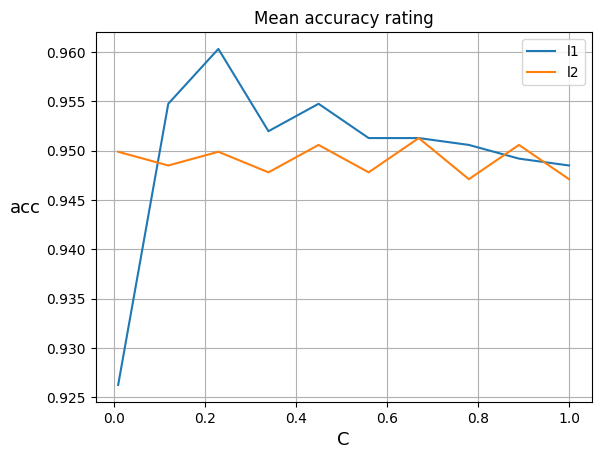

In [51]:
print_cv_results(gs.cv_results_['mean_test_score'],
                 len_c, gs.get_params(), 'C','penalty')

### Newton-cg (Newton’s Method)

Геометрическая интерпретация метода Ньютона заключается в том, что на каждой итерации приближается f(x) квадратичной функцией, а затем делает шаг к максимуму / минимуму этой квадратичной функции.

Недостатки:

1. Затратно с точки зрения вычислений матрицы Гессе (т.е. вычислений вторых частных производных).

2. Может остановиться в седловой точке, которые часто появляются при многопараметрической оптимизации.

In [52]:
%%time
lr = LogisticRegression(solver='newton-cg', penalty='l2')
lr.fit(x_train, y_train)

CPU times: total: 0 ns
Wall time: 65.1 ms


LogisticRegression(solver='newton-cg')

In [53]:
accuracy_score(lr.predict(x_test), y_test)

0.975

In [54]:
%%time
len_c = 10
param_grid={
    'C': np.linspace(0.01, 1, len_c),
    'multi_class': ['ovr', 'multinomial']
    }

gs=GridSearchCV(lr,param_grid=param_grid, cv=3,
                n_jobs=-1, scoring='accuracy')
gs.fit(x_train, y_train)

CPU times: total: 31.2 ms
Wall time: 715 ms


GridSearchCV(cv=3, estimator=LogisticRegression(solver='newton-cg'), n_jobs=-1,
             param_grid={'C': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ]),
                         'multi_class': ['ovr', 'multinomial']},
             scoring='accuracy')

In [55]:
accuracy_score(gs.predict(x_test), y_test)

0.975

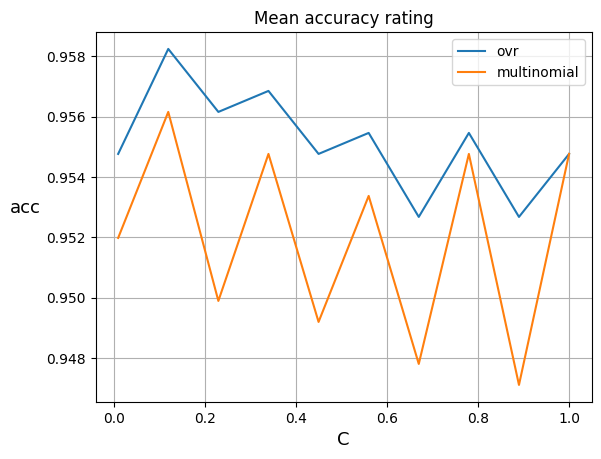

In [56]:
print_cv_results(gs.cv_results_['mean_test_score'],
                 len_c, gs.get_params(), 'C','multi_class')

### Lbfgs (Limited-memory Broyden–Fletcher–Goldfarb–Shanno Algorithm)

Аналог метода Ньютона (квазиньютоновский метод), но здесь матрица Гессе аппроксимируется с использованием оценок градиента.

Ограниченная память означает, что хранится только несколько векторов, которые неявно представляют приближение матрицы.

Solver «lbfgs» рекомендуется использовать для небольших наборов данных, так как для больших наборов данных снижается его производительность.

“lbfgs” solver используется в sklearn по умолчанию из-за его устойчивости.

In [57]:
%%time
lr = LogisticRegression(solver='lbfgs', penalty='l2')
lr.fit(x_train, y_train)

CPU times: total: 0 ns
Wall time: 61.8 ms


LogisticRegression()

In [58]:
accuracy_score(lr.predict(x_test), y_test)

0.9694444444444444

In [59]:
%%time
len_c = 10
param_grid={
    'C': np.linspace(0.01, 1, len_c),
    'multi_class': ['ovr', 'multinomial']
    }

gs=GridSearchCV(lr,param_grid=param_grid, cv=3,
                n_jobs=-1, scoring='accuracy')
gs.fit(x_train, y_train)

CPU times: total: 0 ns
Wall time: 355 ms


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ]),
                         'multi_class': ['ovr', 'multinomial']},
             scoring='accuracy')

In [60]:
accuracy_score(gs.predict(x_test), y_test)

0.975

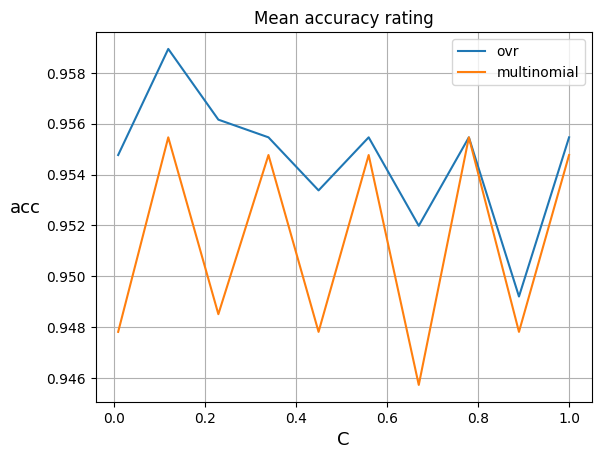

In [61]:
print_cv_results(gs.cv_results_['mean_test_score'],
                 len_c, gs.get_params(), 'C','multi_class')

### Stochatic Average Gradient (SAG)

Объединение градиентного спуска и стохастического.
При этом, он имеет низкую стоимость итерации свойственной SGD, но делает шаг градиента по отношению к аппроксимации полного градиента:


__Недостатки:__
- Нет L1
- Непрактичен для больших выборок, так как имеет высокую вычислительную сложность

In [62]:
%%time
lr = LogisticRegression(solver='sag', penalty='l2')
lr.fit(x_train, y_train)

CPU times: total: 78.1 ms
Wall time: 234 ms


LogisticRegression(solver='sag')

In [63]:
accuracy_score(lr.predict(x_test), y_test)

0.9694444444444444

In [64]:
%%time
len_c = 10
param_grid={
    'C': np.linspace(0.01, 1, len_c),
    'multi_class': ['ovr', 'multinomial']
    }

gs=GridSearchCV(lr,param_grid=param_grid, cv=3,
                n_jobs=-1, scoring='accuracy')
gs.fit(x_train, y_train)

CPU times: total: 46.9 ms
Wall time: 1.35 s


GridSearchCV(cv=3, estimator=LogisticRegression(solver='sag'), n_jobs=-1,
             param_grid={'C': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ]),
                         'multi_class': ['ovr', 'multinomial']},
             scoring='accuracy')

In [65]:
accuracy_score(gs.predict(x_test), y_test)

0.975

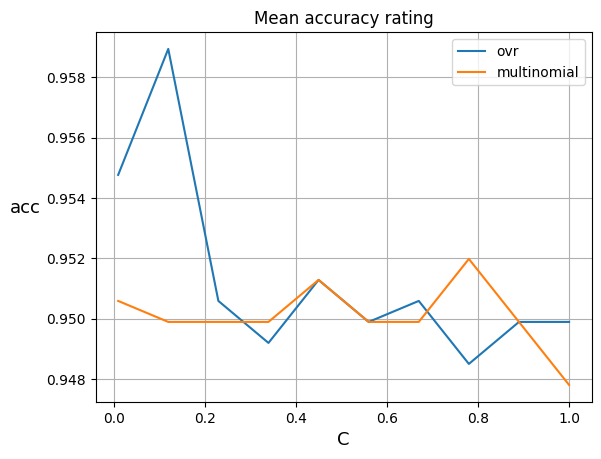

In [66]:
print_cv_results(gs.cv_results_['mean_test_score'],
                 len_c, gs.get_params(), 'C','multi_class')

### Stochatic Average Gradient Augmented (SAGA)

SAGA является вариантом SAG, но который поддерживает опцию non-smooth penalty=l1 (т. е. регуляризацию L1).

Кроме того, это единственный Solver, поддерживающий регуляризацию = "elasticnet" (l1 + l2).

[Подробнее](https://www.di.ens.fr/~fbach/Defazio_NIPS2014.pdf)

In [68]:
lr_clf = LogisticRegression(solver='saga', max_iter=1500)

In [78]:
%%time
len_c = 3
param_grid={
    'C': np.linspace(0.01, 1, len_c),
    #'multi_class': ['ovr', 'multinomial'],
    'penalty': ['l1', 'l2', "elasticnet"]
    }

gs=GridSearchCV(lr_clf,param_grid=param_grid, cv=3,
                n_jobs=-1, scoring='accuracy')
gs.fit(x_train, y_train)

CPU times: total: 62.5 ms
Wall time: 4.76 s


GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=1500, solver='saga'),
             n_jobs=-1,
             param_grid={'C': array([0.01 , 0.505, 1.   ]),
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='accuracy')

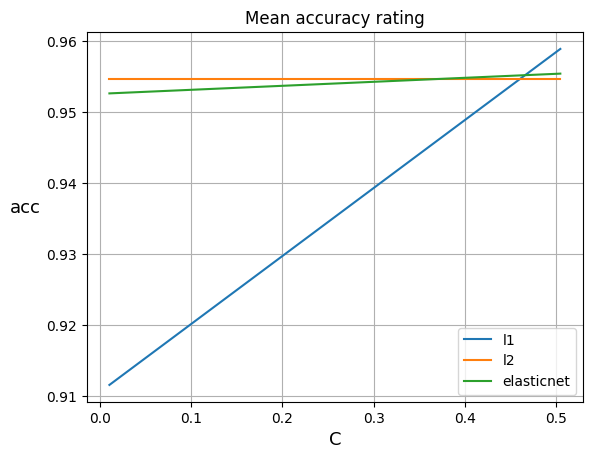

In [79]:
print_cv_results(gs.cv_results_['mean_test_score'],
                 len_c, gs.get_params(), 'C','penalty')

In [81]:
accuracy_score(gs.predict(x_test), y_test)

0.975

<a id="3"></a>
# 3. Intro to PyTorch 
по материалам [DLсourse](https://www.dlschool.org/)

[official PyTorch website](https://pytorch.org/).

<a id="3.1"></a>
## 3.1. Синтаксис

In [84]:
import torch

Some facts about PyTorch:  
- dynamic computation graph
- handy `torch.nn` and `torchvision` modules for fast neural network prototyping
- even faster than TensorFlow on some tasks
- allows to use GPU easily

If PyTorch was a formula, it would be:  

$$PyTorch = NumPy + CUDA + Autograd$$

CUDA - [wiki](https://en.wikipedia.org/wiki/CUDA), Autograd - https://pytorch.org/docs/stable/autograd.html

Let's see how we can use PyTorch to operate with vectors and tensors.  

Recall that **a tensor** is a multidimensional vector, e.g. :  

`x = np.array([1,2,3])` -- a vector = a tensor with 1 dimension (to be more precise: `(1,)`)  
`y = np.array([[1, 2, 3], [4, 5, 6]])` -- a matrix = a tensor with 2 dimensions (`(2, 3)` in this case)  
`z = np.array([[[1, 2, 3], [4, 5, 6], [7, 8, 9]],  
               [[1, 2, 3], [4, 5, 6], [7, 8, 9]],  
               [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])` -- "a cube" (3, 3, 3) = a tensor with 3 dimensions (`(3, 3, 3)` in this case)

One real example of 3-dimensional tensor is **an image**, it has 3 dimensions: `height`, `width` and the `channel depth` (= 3 for color images, 1 for a greyscale). You can think of it as of parallelepiped consisting of the real numbers.

In PyTorch we will use `torch.Tensor` (`FloatTensor`, `IntTensor`, `ByteTensor`) for all the computations.

All tensor types:

In [85]:
torch.HalfTensor      # 16 бит, floating point
torch.FloatTensor     # 32 бита, floating point
torch.DoubleTensor    # 64 бита, floating point

torch.ShortTensor     # 16 бит, integer, signed
torch.IntTensor       # 32 бита, integer, signed
torch.LongTensor      # 64 бита, integer, signed

torch.CharTensor      # 8 бит, integer, signed
torch.ByteTensor      # 8 бит, integer, unsigned

torch.ByteTensor

We will use only `torch.FloatTensor()` and `torch.IntTensor()`.

Let's begin to do something!

* Creating the tensor:

In [86]:
a = torch.FloatTensor([1, 2])
a

tensor([1., 2.])

In [87]:
a.shape

torch.Size([2])

In [88]:
b = torch.FloatTensor([[1,2,3], [4,5,6]])
b

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [89]:
b.shape

torch.Size([2, 3])

In [90]:
x = torch.FloatTensor(2,3,4)

In [91]:
x

tensor([[[3.4413e-21, 1.8988e-42, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]]])

In [92]:
x = torch.FloatTensor(100)
x

tensor([3.5472e-21, 1.8988e-42, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+

In [93]:
x = torch.IntTensor(45, 57, 14, 2)
x.shape

torch.Size([45, 57, 14, 2])

**Note:** if you create `torch.Tensor` with the following constructor it will be filled with the "random trash numbers":

In [94]:
x = torch.IntTensor(3, 2, 4)
x

tensor([[[495060000,      1355,         0,         0],
         [        0,         0,         0,         0]],

        [[        0,         0,         0,         0],
         [        0,         0,         0,         0]],

        [[        0,         0,         0,         0],
         [        0,         0,         0,         0]]], dtype=torch.int32)

Here is a way to fill a new tensor with zeroes:

In [95]:
x = torch.FloatTensor(3, 2, 4).zero_()
x

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.]]])

<a id="3.2"></a>
## 3.2. Операции в PyTorch

All numpy function have its pair in torch.

https://github.com/torch/torch7/wiki/Torch-for-Numpy-users

`np.reshape()` == `torch.view()`:

In [96]:
b

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [97]:
b.view(3, 2)

tensor([[1., 2.],
        [3., 4.],
        [5., 6.]])

**Note:** `torch.view()` creates a new tensor, one the old one remains unchanged

In [98]:
b.view(-1)

tensor([1., 2., 3., 4., 5., 6.])

In [99]:
b

tensor([[1., 2., 3.],
        [4., 5., 6.]])

* Change a tensor type:

In [100]:
a = torch.FloatTensor([1.5, 3.2, -7])

In [101]:
a.type_as(torch.IntTensor())

tensor([ 1,  3, -7], dtype=torch.int32)

In [102]:
a.type_as(torch.ByteTensor())

tensor([  1,   3, 249], dtype=torch.uint8)

**Note:** `.type_as()` creates a new tensor, the old one remains unchanged

In [103]:
a

tensor([ 1.5000,  3.2000, -7.0000])

* Indexing is just like in `NumPy`:

In [104]:
a = torch.FloatTensor([[100, 20, 35], [15, 163, 534], [52, 90, 66]])
a

tensor([[100.,  20.,  35.],
        [ 15., 163., 534.],
        [ 52.,  90.,  66.]])

In [105]:
a[0, 0]

tensor(100.)

In [106]:
a[0:2, 0:2]

tensor([[100.,  20.],
        [ 15., 163.]])

**Ariphmetics and boolean operations** and their analogues:  

| Operator | Analogue |
|:-:|:-:|
|`+`| `torch.add()` |
|`-`| `torch.sub()` |
|`*`| `torch.mul()` |
|`/`| `torch.div()` |

* Addition:

In [107]:
a = torch.FloatTensor([[1, 2, 3], [10, 20, 30], [100, 200, 300]])
b = torch.FloatTensor([[-1, -2, -3], [-10, -20, -30], [100, 200, 300]])

In [108]:
a + b

tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [200., 400., 600.]])

In [109]:
a.add(b)

tensor([[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [200., 400., 600.]])

In [110]:
b = -a
b

tensor([[  -1.,   -2.,   -3.],
        [ -10.,  -20.,  -30.],
        [-100., -200., -300.]])

In [111]:
a + b

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

* Subtraction:

In [112]:
a - b

tensor([[  2.,   4.,   6.],
        [ 20.,  40.,  60.],
        [200., 400., 600.]])

In [113]:
a.sub(b)

tensor([[  2.,   4.,   6.],
        [ 20.,  40.,  60.],
        [200., 400., 600.]])

* Multiplication (elementwise):

In [114]:
a * b

tensor([[-1.0000e+00, -4.0000e+00, -9.0000e+00],
        [-1.0000e+02, -4.0000e+02, -9.0000e+02],
        [-1.0000e+04, -4.0000e+04, -9.0000e+04]])

In [115]:
a.mul(b)

tensor([[-1.0000e+00, -4.0000e+00, -9.0000e+00],
        [-1.0000e+02, -4.0000e+02, -9.0000e+02],
        [-1.0000e+04, -4.0000e+04, -9.0000e+04]])

* Division (elementwise):

In [116]:
a = torch.FloatTensor([[1, 2, 3], [10, 20, 30], [100, 200, 300]])
b = torch.FloatTensor([[-1, -2, -3], [-10, -20, -30], [100, 200, 300]])

In [117]:
a / b

tensor([[-1., -1., -1.],
        [-1., -1., -1.],
        [ 1.,  1.,  1.]])

In [118]:
a.div(b)

tensor([[-1., -1., -1.],
        [-1., -1., -1.],
        [ 1.,  1.,  1.]])

**Note:** all this operations create new tensors, the old tensors remain unchanged

In [119]:
a

tensor([[  1.,   2.,   3.],
        [ 10.,  20.,  30.],
        [100., 200., 300.]])

In [120]:
b

tensor([[ -1.,  -2.,  -3.],
        [-10., -20., -30.],
        [100., 200., 300.]])

* Comparison operators:

In [121]:
a = torch.FloatTensor([[1, 2, 3], [10, 20, 30], [100, 200, 300]])
b = torch.FloatTensor([[-1, -2, -3], [-10, -20, -30], [100, 200, 300]])

In [122]:
a == b

tensor([[False, False, False],
        [False, False, False],
        [ True,  True,  True]])

In [123]:
a != b

tensor([[ True,  True,  True],
        [ True,  True,  True],
        [False, False, False]])

In [124]:
a < b

tensor([[False, False, False],
        [False, False, False],
        [False, False, False]])

In [125]:
a > b

tensor([[ True,  True,  True],
        [ True,  True,  True],
        [False, False, False]])

* Using boolean mask indexing:

In [126]:
a[a > b]

tensor([ 1.,  2.,  3., 10., 20., 30.])

In [127]:
b[a == b]

tensor([100., 200., 300.])

Elementwise application of the **universal functions**:

In [128]:
a = torch.FloatTensor([[1, 2, 3], [10, 20, 30], [100, 200, 300]])

In [129]:
a.sin()

tensor([[ 0.8415,  0.9093,  0.1411],
        [-0.5440,  0.9129, -0.9880],
        [-0.5064, -0.8733, -0.9998]])

In [130]:
torch.sin(a)

tensor([[ 0.8415,  0.9093,  0.1411],
        [-0.5440,  0.9129, -0.9880],
        [-0.5064, -0.8733, -0.9998]])

In [131]:
a.tan()

tensor([[ 1.5574, -2.1850, -0.1425],
        [ 0.6484,  2.2372, -6.4053],
        [-0.5872, -1.7925, 45.2447]])

In [132]:
a.exp()

tensor([[2.7183e+00, 7.3891e+00, 2.0086e+01],
        [2.2026e+04, 4.8517e+08, 1.0686e+13],
        [       inf,        inf,        inf]])

In [133]:
a.log()

tensor([[0.0000, 0.6931, 1.0986],
        [2.3026, 2.9957, 3.4012],
        [4.6052, 5.2983, 5.7038]])

In [134]:
b = -a
b

tensor([[  -1.,   -2.,   -3.],
        [ -10.,  -20.,  -30.],
        [-100., -200., -300.]])

In [135]:
b.abs()

tensor([[  1.,   2.,   3.],
        [ 10.,  20.,  30.],
        [100., 200., 300.]])

* The sum, mean, max, min:

In [136]:
a.sum()

tensor(666.)

In [137]:
a.mean()

tensor(74.)

Along axis:

In [138]:
a

tensor([[  1.,   2.,   3.],
        [ 10.,  20.,  30.],
        [100., 200., 300.]])

In [139]:
a.sum(dim=0)

tensor([111., 222., 333.])

In [140]:
a.sum(1)

tensor([  6.,  60., 600.])

In [141]:
a.max()

tensor(300.)

In [142]:
a.max(0)

torch.return_types.max(
values=tensor([100., 200., 300.]),
indices=tensor([2, 2, 2]))

In [143]:
a.min()

tensor(1.)

In [144]:
a.min(0)

torch.return_types.min(
values=tensor([1., 2., 3.]),
indices=tensor([0, 0, 0]))

**Note:** the second tensor returned by `.max()` and `.min()` contains the indices of max/min elements along this axis. E.g. in that case `a.min()` returned `(1, 2, 3)` which are the minimum elements along 0 axis (along columns) and their indices along 0 axis are `(0, 0, 0)`.

<a id="3.3"></a>
## 3.3. Matrix operations

* Transpose a tensor:

In [145]:
a = torch.FloatTensor([[1, 2, 3], [10, 20, 30], [100, 200, 300]])
a

tensor([[  1.,   2.,   3.],
        [ 10.,  20.,  30.],
        [100., 200., 300.]])

In [146]:
a.t()

tensor([[  1.,  10., 100.],
        [  2.,  20., 200.],
        [  3.,  30., 300.]])

It is not not the inplace operation too:

In [147]:
a

tensor([[  1.,   2.,   3.],
        [ 10.,  20.,  30.],
        [100., 200., 300.]])

* Dot product of vectors:

In [148]:
a = torch.FloatTensor([1, 2, 3, 4, 5, 6])
b = torch.FloatTensor([-1, -2, -4, -6, -8, -10])

In [149]:
a.dot(b)

tensor(-141.)

In [150]:
a.shape, b.shape

(torch.Size([6]), torch.Size([6]))

In [151]:
a @ b

tensor(-141.)

In [152]:
type(a)

torch.Tensor

In [153]:
type(b)

torch.Tensor

In [154]:
type(a @ b)

torch.Tensor

* Matrix product:

In [155]:
a = torch.FloatTensor([[1, 2, 3], [10, 20, 30], [100, 200, 300]])
b = torch.FloatTensor([[-1, -2, -3], [-10, -20, -30], [100, 200, 300]])

In [156]:
a.mm(b)

tensor([[  279.,   558.,   837.],
        [ 2790.,  5580.,  8370.],
        [27900., 55800., 83700.]])

In [157]:
a @ b

tensor([[  279.,   558.,   837.],
        [ 2790.,  5580.,  8370.],
        [27900., 55800., 83700.]])

Remain unchanged:

In [158]:
a

tensor([[  1.,   2.,   3.],
        [ 10.,  20.,  30.],
        [100., 200., 300.]])

In [159]:
b

tensor([[ -1.,  -2.,  -3.],
        [-10., -20., -30.],
        [100., 200., 300.]])

In [160]:
a = torch.FloatTensor([[1, 2, 3], [10, 20, 30], [100, 200, 300]])
b = torch.FloatTensor([[-1], [-10], [100]])

In [161]:
print(a.shape, b.shape)

torch.Size([3, 3]) torch.Size([3, 1])


In [162]:
a @ b

tensor([[  279.],
        [ 2790.],
        [27900.]])

If we unroll the tensor `b` in an array (`torch.view(-1)`) the multiplication would be like with the column:

In [163]:
b

tensor([[ -1.],
        [-10.],
        [100.]])

In [164]:
b.view(-1)

tensor([ -1., -10., 100.])

In [165]:
a @ b.view(-1)

tensor([  279.,  2790., 27900.])

In [166]:
a.mv(b.view(-1))

tensor([  279.,  2790., 27900.])

<a id="3.4"></a>
## 3.4. From NumPy to PyTorch conversion

In [167]:
import numpy as np

a = np.random.rand(3, 3)
a

array([[0.31301861, 0.42247613, 0.00186042],
       [0.68928121, 0.14495587, 0.93701016],
       [0.79312564, 0.74942862, 0.06825185]])

In [168]:
b = torch.from_numpy(a)
b

tensor([[0.3130, 0.4225, 0.0019],
        [0.6893, 0.1450, 0.9370],
        [0.7931, 0.7494, 0.0683]], dtype=torch.float64)

**NOTE!** `a` and `b` have the same data storage, so the changes in one tensor will lead to the changes in another:

In [169]:
b -= b
b

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)

In [170]:
a

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

From PyTorch to NumPy conversion:

In [171]:
a = torch.FloatTensor(2, 3, 4)
a

tensor([[[3.4416e-21, 1.8988e-42, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]]])

In [172]:
type(a)

torch.Tensor

In [173]:
x = a.numpy()
x

array([[[3.4415754e-21, 1.8987594e-42, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00]]],
      dtype=float32)

In [174]:
x.shape

(2, 3, 4)

In [175]:
type(x)

numpy.ndarray

In [176]:
x -= x

In [177]:
a

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]])

Let's write the `forward_pass(X, w)` ($w_0$ is a part of the $w$) for a single neuron (activation = sigmoid) using PyTorch:

In [178]:
def forward_pass(X, w):
    return torch.sigmoid(X @ w)

In [179]:
X = torch.FloatTensor([[-5, 5],
                       [2, 3],
                       [1, -1]])

w = torch.FloatTensor([[-0.5],
                       [2.5]])

result = forward_pass(X, w)
print('result: {}'.format(result))

result: tensor([[1.0000],
        [0.9985],
        [0.0474]])


<a id="3.5"></a>
## 3.5. CUDA

[CUDA documentation](https://docs.nvidia.com/cuda/)

We can use both CPU (Central Processing Unit) and GPU (Graphical Processing Unit) to make the computations with PyTorch. We can switch between them easily, this is one of the most important things in PyTorch framework.

How to make CUDA available on your computer: https://pytorch.org/get-started/locally/

In [180]:
torch.cuda.is_available()

True

In [181]:
x = torch.FloatTensor(1024, 1024).uniform_()
x

tensor([[0.5207, 0.3491, 0.3074,  ..., 0.4788, 0.8302, 0.9901],
        [0.1617, 0.5054, 0.7731,  ..., 0.5674, 0.9197, 0.5493],
        [0.7125, 0.6637, 0.5517,  ..., 0.5838, 0.1348, 0.2607],
        ...,
        [0.0911, 0.9431, 0.0943,  ..., 0.8857, 0.4333, 0.5966],
        [0.0726, 0.3677, 0.8097,  ..., 0.0479, 0.0728, 0.9766],
        [0.9476, 0.9542, 0.3232,  ..., 0.0428, 0.7131, 0.9922]])

In [182]:
x.is_cuda

False

Place a tensor on GPU:

In [183]:
x = x.cuda()

In [184]:
x

tensor([[0.5207, 0.3491, 0.3074,  ..., 0.4788, 0.8302, 0.9901],
        [0.1617, 0.5054, 0.7731,  ..., 0.5674, 0.9197, 0.5493],
        [0.7125, 0.6637, 0.5517,  ..., 0.5838, 0.1348, 0.2607],
        ...,
        [0.0911, 0.9431, 0.0943,  ..., 0.8857, 0.4333, 0.5966],
        [0.0726, 0.3677, 0.8097,  ..., 0.0479, 0.0728, 0.9766],
        [0.9476, 0.9542, 0.3232,  ..., 0.0428, 0.7131, 0.9922]],
       device='cuda:0')

In [185]:
device = torch.device("cuda:0")
x = x.to(device)
x

tensor([[0.5207, 0.3491, 0.3074,  ..., 0.4788, 0.8302, 0.9901],
        [0.1617, 0.5054, 0.7731,  ..., 0.5674, 0.9197, 0.5493],
        [0.7125, 0.6637, 0.5517,  ..., 0.5838, 0.1348, 0.2607],
        ...,
        [0.0911, 0.9431, 0.0943,  ..., 0.8857, 0.4333, 0.5966],
        [0.0726, 0.3677, 0.8097,  ..., 0.0479, 0.0728, 0.9766],
        [0.9476, 0.9542, 0.3232,  ..., 0.0428, 0.7131, 0.9922]],
       device='cuda:0')

Let's multiply two tensors on GPU and then move the result on the CPU:

In [186]:
a = torch.FloatTensor(10000, 10000).uniform_()
b = torch.FloatTensor(10000, 10000).uniform_()
c = a.cuda().mul(b.cuda()).cpu()

In [187]:
c

tensor([[0.1399, 0.0834, 0.0022,  ..., 0.2397, 0.5072, 0.6354],
        [0.0442, 0.8165, 0.6167,  ..., 0.1516, 0.2879, 0.4198],
        [0.1726, 0.0044, 0.0189,  ..., 0.4561, 0.0364, 0.7179],
        ...,
        [0.2041, 0.0032, 0.0991,  ..., 0.1665, 0.4861, 0.7355],
        [0.6071, 0.1240, 0.0273,  ..., 0.1316, 0.0937, 0.3424],
        [0.1689, 0.2901, 0.2354,  ..., 0.0024, 0.1677, 0.2444]])

In [188]:
a

tensor([[0.3620, 0.0993, 0.0089,  ..., 0.3539, 0.7964, 0.8494],
        [0.0447, 0.8983, 0.9433,  ..., 0.5526, 0.3904, 0.6130],
        [0.3549, 0.8304, 0.1481,  ..., 0.6765, 0.0435, 0.9751],
        ...,
        [0.4573, 0.0182, 0.1348,  ..., 0.5420, 0.5712, 0.8940],
        [0.7216, 0.2334, 0.0355,  ..., 0.8369, 0.5063, 0.6083],
        [0.9399, 0.5534, 0.2692,  ..., 0.6454, 0.2493, 0.9678]])

Tensors placed on CPU and tensors placed on GPU are unavailable for each other:

In [189]:
a = torch.FloatTensor(10000, 10000).uniform_().cpu()
b = torch.FloatTensor(10000, 10000).uniform_().cuda()

In [190]:
a + b

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

Example of working with GPU:

In [191]:
x = torch.FloatTensor(5, 5, 5).uniform_()

# check for CUDA availability (NVIDIA GPU)
if torch.cuda.is_available():
    # get the CUDA device name
    device = torch.device('cuda')          # CUDA-device object
    y = torch.ones_like(x, device=device)  # create a tensor on GPU
    x = x.to(device)                       # or just `.to("cuda")`
    z = x + y
    print(z)
    # you can set the type while `.to` operation
    print(z.to("cpu", torch.double))

tensor([[[1.9317, 1.6385, 1.6399, 1.9606, 1.2427],
         [1.7882, 1.6631, 1.6239, 1.0459, 1.0331],
         [1.5650, 1.4954, 1.8335, 1.6795, 1.1918],
         [1.5632, 1.5145, 1.4368, 1.8312, 1.5093],
         [1.7234, 1.4101, 1.6354, 1.6247, 1.0180]],

        [[1.3972, 1.9416, 1.5292, 1.9183, 1.4432],
         [1.0959, 1.4077, 1.1100, 1.4613, 1.8940],
         [1.8559, 1.8168, 1.4797, 1.4297, 1.8629],
         [1.7411, 1.7837, 1.4112, 1.0908, 1.5804],
         [1.7158, 1.1350, 1.9502, 1.9103, 1.8117]],

        [[1.0993, 1.3921, 1.5731, 1.1522, 1.5722],
         [1.7301, 1.2442, 1.4185, 1.9124, 1.4982],
         [1.4794, 1.1797, 1.0211, 1.0566, 1.8583],
         [1.4553, 1.0837, 1.7136, 1.7716, 1.1342],
         [1.1067, 1.3284, 1.4877, 1.5974, 1.5345]],

        [[1.4553, 1.1368, 1.5500, 1.1804, 1.0221],
         [1.6330, 1.2302, 1.3746, 1.8464, 1.9126],
         [1.9960, 1.6409, 1.8951, 1.4490, 1.8782],
         [1.7218, 1.7993, 1.8224, 1.9685, 1.6250],
         [1.2435, 1.2476,

<a id="4"></a>
# 4. High-level PyTorch

So far we've been dealing with low-level torch API. While it's absolutely vital for any custom losses or layers, building large neura nets in it is a bit clumsy.

Luckily, there's also a high-level torch interface with a pre-defined layers, activations and training algorithms.

We'll cover them as we go through a simple image recognition problem


In [198]:
from sklearn.datasets import load_digits
dataset = load_digits()

features = dataset.data
target = dataset.target

features.shape, target.shape

((1797, 64), (1797,))

In [199]:
from sklearn.model_selection import train_test_split

In [200]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25)

print(X_train.shape, y_train.shape)

(1347, 64) (1347,)


In [201]:
binary_train_mask = (y_train == 0) | (y_train == 1)
X_train = X_train[binary_train_mask]
y_train = y_train[binary_train_mask]

binary_test_mask = (y_test == 0) | (y_test == 1)
X_test = X_test[binary_test_mask]
y_test = y_test[binary_test_mask]

In [202]:
y_test

array([1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1])

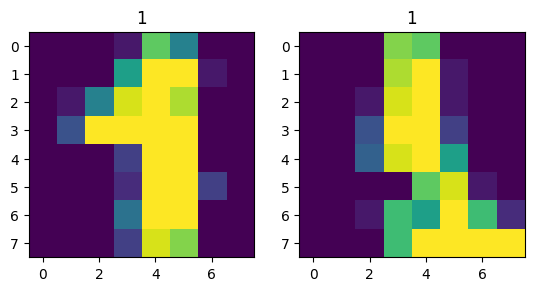

In [203]:
for i in [0,1]:
    plt.subplot(1, 2, i + 1)
    plt.imshow(X_train[i].reshape([8,8]))
    plt.title(str(y_train[i]))

Let's start with layers. The main abstraction here is __`torch.nn.Module`__

In [204]:
from torch import nn
import torch.nn.functional as F

print(nn.Module.__doc__)

Base class for all neural network modules.

    Your models should also subclass this class.

    Modules can also contain other Modules, allowing to nest them in
    a tree structure. You can assign the submodules as regular attributes::

        import torch.nn as nn
        import torch.nn.functional as F

        class Model(nn.Module):
            def __init__(self):
                super().__init__()
                self.conv1 = nn.Conv2d(1, 20, 5)
                self.conv2 = nn.Conv2d(20, 20, 5)

            def forward(self, x):
                x = F.relu(self.conv1(x))
                return F.relu(self.conv2(x))

    Submodules assigned in this way will be registered, and will have their
    parameters converted too when you call :meth:`to`, etc.

    .. note::
        As per the example above, an ``__init__()`` call to the parent class
        must be made before assignment on the child.

    :ivar training: Boolean represents whether this module is in training or
         

There's a vast library of popular layers and architectures already built for ya'.

This is a binary classification problem, so we'll train a __Logistic Regression with sigmoid__.
$$P(y_i | X_i) = \sigma(W \cdot X_i + b) ={ 1 \over {1+e^{- [W \cdot X_i + b]}} }$$


In [206]:
# create a network that stacks layers on top of each other
model = nn.Sequential()

# add first "dense" layer with 64 input units and 1 output unit.
model.add_module('l1', nn.Linear(64, 1))

# add softmax activation for probabilities. Normalize over axis 1
# note: layer names must be unique
model.add_module('l2', nn.Sigmoid())

In [206]:
print("Weight shapes:", [w.shape for w in model.parameters()])

Weight shapes: [torch.Size([1, 64]), torch.Size([1])]


In [207]:
# create dummy data with 3 samples and 64 features
x = torch.tensor(X_train[:3], dtype=torch.float32)
y = torch.tensor(y_train[:3], dtype=torch.float32)

# compute outputs given inputs, both are variables
y_predicted = model(x)[:, 0]

y_predicted # display what we've got

tensor([0.3693, 0.9056, 0.9996], grad_fn=<SelectBackward0>)

Let's now define a loss function for our model.

The natural choice is to use binary crossentropy (aka logloss, negative llh):
$$ L = {1 \over N} \underset{X_i,y_i} \sum - [  y_i \cdot log P(y_i | X_i) + (1-y_i) \cdot log (1-P(y_i | X_i)) ]$$



In [208]:
F.binary_cross_entropy

<function torch.nn.functional.binary_cross_entropy(input: torch.Tensor, target: torch.Tensor, weight: Optional[torch.Tensor] = None, size_average: Optional[bool] = None, reduce: Optional[bool] = None, reduction: str = 'mean') -> torch.Tensor>

In [209]:
loss = F.binary_cross_entropy(y_predicted, y)

In [210]:
loss

tensor(2.9918, grad_fn=<BinaryCrossEntropyBackward0>)

__Note:__ you can also find many such functions in `torch.nn.functional`, just type __`F.<tab>`__.

__Torch optimizers__

When we trained Linear Regression above, we had to manually .zero_() gradients on both our variables. Imagine that code for a 50-layer network.

Again, to keep it from getting dirty, there's `torch.optim` module with pre-implemented algorithms:

In [211]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

# here's how it's used:
loss.backward()      # add new gradients
opt.step()           # change weights
opt.zero_grad()      # clear gradients

In [212]:
# dispose of old variables to avoid bugs later
del x, y, y_predicted, loss

### Putting it all together

In [213]:
from torch import nn
import torch.nn.functional as F

# create network again just in case
model = nn.Sequential()
model.add_module('first', nn.Linear(64, 1))
model.add_module('second', nn.Sigmoid())


opt = torch.optim.SGD(model.parameters(), lr=1e-3)

In [214]:
history = []

for i in range(1000):

    # sample 256 random images
    indices = torch.randperm(len(X_train))[:256]
    x = torch.from_numpy(X_train[indices]).type_as(torch.FloatTensor())
    y = torch.from_numpy(y_train[indices]).type_as(torch.FloatTensor())

    # predict probabilities
    y_predicted = model(x)[:, 0]


    assert y_predicted.dim() == 1, "did you forget to select first column with [:, 0]"

    # compute loss, just like before
    loss = F.binary_cross_entropy(y_predicted, y)


    # compute gradients
    loss.backward()

    # SGD step
    opt.step()   

    # clear gradients
    opt.zero_grad()



    history.append(loss.data.numpy())

    if i % 10 == 0:
        print("step #%i | mean loss = %.3f" % (i, np.mean(history[-10:])))

step #0 | mean loss = 3.063
step #10 | mean loss = 1.398
step #20 | mean loss = 0.422
step #30 | mean loss = 0.220
step #40 | mean loss = 0.152
step #50 | mean loss = 0.111
step #60 | mean loss = 0.091
step #70 | mean loss = 0.075
step #80 | mean loss = 0.066
step #90 | mean loss = 0.057
step #100 | mean loss = 0.052
step #110 | mean loss = 0.046
step #120 | mean loss = 0.042
step #130 | mean loss = 0.038
step #140 | mean loss = 0.035
step #150 | mean loss = 0.033
step #160 | mean loss = 0.030
step #170 | mean loss = 0.029
step #180 | mean loss = 0.027
step #190 | mean loss = 0.026
step #200 | mean loss = 0.025
step #210 | mean loss = 0.024
step #220 | mean loss = 0.022
step #230 | mean loss = 0.021
step #240 | mean loss = 0.021
step #250 | mean loss = 0.020
step #260 | mean loss = 0.019
step #270 | mean loss = 0.018
step #280 | mean loss = 0.017
step #290 | mean loss = 0.017
step #300 | mean loss = 0.016
step #310 | mean loss = 0.016
step #320 | mean loss = 0.016
step #330 | mean loss

__Debugging tips:__
* make sure your model predicts probabilities correctly. Just print them and see what's inside.
* don't forget _minus_ sign in the loss function! It's a mistake 99% ppl do at some point.
* make sure you zero-out gradients after each step. Srsly:)
* In general, pytorch's error messages are quite helpful, read 'em before you google 'em.
* if you see nan/inf, print what happens at each iteration to find our where exactly it occurs.
  * If loss goes down and then turns nan midway through, try smaller learning rate. (Our current loss formula is unstable).


### Evaluation

Let's see how our model performs on test data

In [215]:
X_test

array([[ 0.,  0.,  6., ...,  8.,  0.,  0.],
       [ 0.,  0.,  1., ..., 15.,  1.,  0.],
       [ 0.,  0.,  5., ...,  8.,  0.,  0.],
       ...,
       [ 0.,  0.,  4., ...,  6.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  1.,  0.],
       [ 0.,  0.,  0., ...,  2.,  0.,  0.]])

In [216]:
# use your model to predict classes (0 or 1) for all test samples
predicted_y_test = model(torch.tensor(X_test, dtype=torch.float32))[:, 0]
predicted_y_test = np.array(predicted_y_test > 0.5)

assert isinstance(predicted_y_test, np.ndarray), "please return np array, not %s" % type(predicted_y_test)
assert predicted_y_test.shape == y_test.shape, "please predict one class for each test sample"
assert np.in1d(predicted_y_test, y_test).all(), "please predict class indexes"

accuracy = np.mean(predicted_y_test == y_test)

print("Test accuracy: %.5f" % accuracy)
assert accuracy > 0.95, "try training longer"

print('Great job!')

Test accuracy: 1.00000
Great job!


### More about pytorch:
* Using torch on GPU and multi-GPU - [link](http://pytorch.org/docs/master/notes/cuda.html)
* More tutorials on pytorch - [link](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* Pytorch examples - a repo that implements many cool DL models in pytorch - [link](https://github.com/pytorch/examples)
* Practical pytorch - a repo that implements some... other cool DL models... yes, in pytorch - [link](https://github.com/spro/practical-pytorch)
* And some more - [link](https://www.reddit.com/r/pytorch/comments/6z0yeo/pytorch_and_pytorch_tricks_for_kaggle/)

<a id="5"></a>
# 5. Ссылки

*1). Official PyTorch tutorials: https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py*

*2). arXiv article about the deep learning frameworks comparison: https://arxiv.org/pdf/1511.06435.pdf*

*3). Useful repo with different tutorials: https://github.com/yunjey/pytorch-tutorial*

*4). Facebook AI Research (main contributor of PyTorch) website: https://facebook.ai/developers/tools*

<a id="6"></a>
# 6. Что почитать:
- [Regularized Logistic Regression is Strictly Convex](http://www.qwone.com/~jason/writing/convexLR.pdf)
- [SAGA: A Fast Incremental Gradient Method With Support for Non-Strongly Convex Composite Objectives
](https://www.di.ens.fr/~fbach/Defazio_NIPS2014.pdf)
- [Лекции Евгения Соколова](https://github.com/esokolov/ml-course-hse/tree/master/2018-fall/lecture-notes)
- [Всё про метрики классификации и регрессии](https://education.yandex.ru/handbook/ml/article/metriki-klassifikacii-i-regressii#mnogoklassovaya-klassifikaciya)